In [ ]:
import os
from PIL import Image


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_examples = 19900
test_examples = 6774
validation_examples = 6451

img_height = img_width = 224
batch_size = 50


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    dtype=None,
)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=None)
test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=None)


In [ ]:
train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)


Found 19900 images belonging to 2 classes.


In [ ]:
validation_gen = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/validation",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)


Found 6451 images belonging to 2 classes.


In [ ]:
test_gen = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

Found 6774 images belonging to 2 classes.


In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)


In [ ]:
model.fit(
    train_gen,
    epochs=1,
    verbose=2,
    steps_per_epoch=train_examples // batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples // batch_size,
    )


398/398 - 26190s - loss: 0.3066 - accuracy: 0.9803 - precision: 0.0217 - recall: 0.0029 - auc: 0.7823 - val_loss: 0.2944 - val_accuracy: 0.9840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7767 - 26190s/epoch - 66s/step


In [ ]:
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.show()

136/136 [==============================] - 997s 7s/step


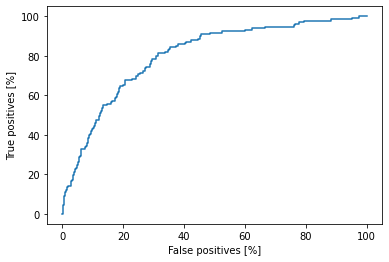

130/130 - 966s - loss: 0.2944 - accuracy: 0.9840 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7767 - 966s/epoch - 7s/step
136/136 - 1010s - loss: 0.3115 - accuracy: 0.9804 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7853 - 1010s/epoch - 7s/step


[0.3114950358867645, 0.9803661108016968, 0.0, 0.0, 0.7853260040283203]

In [ ]:
test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(test_examples / batch_size):
        break

plot_roc(test_labels, test_gen)
model.evaluate(validation_gen, verbose=2)
model.evaluate(test_gen, verbose=2)